### M637 Project Notebook
Pro Kumar

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import math
import statistics as stat
import time
import os, shutil
import matplotlib.pyplot as plt
import PIL
import random
import h5py
from matplotlib.image import imread
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, activations
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, models, layers, regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.optimizers import RMSprop
from PIL import Image, ImageOps
from numpy import asarray
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

Using TensorFlow backend.


***

### Generate RGB Arrays/Labels

In [3]:
# Looping over full b cancer img directory
directory = 'b_cancer_ims'
labels_n = [] # 0 = no IDC, 1 = IDC
labels_p = [] 
ims2_p = [] # populate with + images
ims2_n = [] 

start_pat1 = 93 # random.randint(1,270) # len(os.listdir(directory)) = 280
end_pat = start_pat1 + 7 # Don't want too many images

for folder1 in os.listdir(directory)[start_pat1:end_pat]:
    for folder2 in os.listdir(directory+'/'+folder1):
        for image in os.listdir(directory+'/'+folder1+'/'+folder2)[1:]: #first path not-included
            #print(directory+'/'+folder1+'/'+folder2+'/'+image)
            im = Image.open(directory+'/'+folder1+'/'+folder2+'/'+image) ################################ RGB
            if im.size == (50,50): # Discarding non-standardized images
                if (image[-5]=='0'):
                    ims2_n.append(asarray(im)/255)
                    labels_n.append(0)
                else:
                    ims2_p.append(asarray(im)/255)
                    labels_p.append(1)

ims2_n = np.array(ims2_n)
ims2_p = np.array(ims2_p)
labels_p = np.array(labels_p)
labels_n = np.array(labels_n)

# Equalize num of +/- cases
if len(ims2_p)<len(ims2_n):
    ims2_n = ims2_n[0:len(ims2_p)]
    labels_n = labels_n[0:len(labels_p)]
else: 
    ims2_p = ims2_p[0:len(ims2_n)]
    labels_p = labels_p[0:len(labels_n)]
    
labels = np.concatenate((labels_p,labels_n))
ims2 = np.concatenate((ims2_p,ims2_n))

unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
print('Total instances = ',2*counts[0])

{0: 1599, 1: 1599}
Total instances =  3198


### Create Train Test Split of this data set & form grayscale images

In [4]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(ims2, labels, test_size=0.25)

RGB array to Gray Array Formula from [Pillow documentation](https://pillow.readthedocs.io/en/3.1.x/reference/Image.html).

In [5]:
ims2_gray_xtrain = []
ims2_gray_xtest = []

for i in range(len(x_train2)):
    ims2_gray_xtrain.append(np.dot(x_train2[i],[0.299, 0.587, 0.114]))

for i in range(len(x_test2)):
    ims2_gray_xtest.append(np.dot(x_test2[i],[0.299, 0.587, 0.114]))

print(len(ims2_gray_xtrain),'and',len(ims2_gray_xtest))

ims2_gray_xtrain = np.array(ims2_gray_xtrain)
ims2_gray_xtest = np.array(ims2_gray_xtest)

2398 and 800


***

### TF Tutorial NN on Gray

In [5]:
scores0 = []
n=50
for i in range(20): 
    gray_model = keras.Sequential([
            keras.layers.Flatten(input_shape=(n,n)),
            keras.layers.Dense(128, activation='relu'), # Originally 128 units
            keras.layers.Dense(10)
        ])

    gray_model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

    # Fit NN model to train-split with 10 epochs
    gray_model.fit(ims2_gray_xtrain, y_train2, epochs=10,verbose=0)

    # Calculate accuracy on test-split
    test_loss, test_acc = gray_model.evaluate(ims2_gray_xtest,  y_test2, verbose=0)
    scores0.append(test_acc)

print(np.mean(scores0))
print(np.std(scores0))

0.57087505
0.0762501


In [ ]:
test_loss, test_acc = gray_model.evaluate(ims2_gray_xtest,  y_test2, verbose=0)
print(test_acc)

#### Gray Generalizability

In [6]:
scores2 = []
n=50
for i in range(20):
    gray_model = keras.Sequential([
            keras.layers.Flatten(input_shape=(n,n)),
            keras.layers.Dense(128, activation='relu'), # Originally 128 units
            keras.layers.Dense(10)
        ])

    gray_model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

    # Fit NN model to train-split with 10 epochs
    gray_model.fit(ims2_gray_xtrain, y_train2, epochs=10,verbose=0)

    # Calculate accuracy on test-split
    test_loss, test_acc = gray_model.evaluate(ims2_gray_xtest,  y_test2, verbose=0)
    scores2.append(test_acc)

print(np.mean(scores2))
print(np.std(scores2))

0.625625
0.05812499


In [64]:
directory = 'b_cancer_ims'
gray_accs = []
for i in range(30):
    gray_test_labels = [] # 0 = no IDC, 1 = IDC
    gray_test_ims = [] # populate with + images

    # Selecting random group of conseccutive patients
    start_pat1 = random.randint(1,270) # len(os.listdir(directory)) = 280
    end_pat = start_pat1 + random.randint(1,3) # Picking at most 3 patients worth of data. Want quick computations

    for folder1 in os.listdir(directory)[start_pat1:end_pat]:
        for folder2 in os.listdir(directory+'/'+folder1):
            for image in os.listdir(directory+'/'+folder1+'/'+folder2)[1:]: #first path not-included
                #print(directory+'/'+folder1+'/'+folder2+'/'+image)
                im = Image.open(directory+'/'+folder1+'/'+folder2+'/'+image).convert('L') ################ Gray
                if im.size == (50,50): # Discarding non-standardized images.
                    if (image[-5]=='0'):
                        gray_test_ims.append(asarray(im)/255)
                        gray_test_labels.append(0)
                    else:
                        gray_test_ims.append(asarray(im)/255)
                        gray_test_labels.append(1)

    gray_test_ims = np.array(gray_test_ims)
    gray_test_labels = np.array(gray_test_labels)
    
    print(start_pat1)
    test_loss, test_acc = gray_model.evaluate(gray_test_ims, gray_test_labels, verbose=0)
    gray_accs.append(test_acc)

269
196
165
27
200
177
109
192
114
184
128
145
39
211
140
157
173
192
215
240
174
26
110
157
181
93
196
46
4
179


In [65]:
print(np.mean(gray_accs))
print(np.std(gray_accs))

0.6621306
0.12588732


***

### TF Tutorial NN on RGB

In [11]:
scores1 = []
n=50
for i in range(20):
    rgb_model = keras.Sequential([
            keras.layers.Flatten(input_shape=(n,n,3)),
            keras.layers.Dense(128, activation='relu'), # Originally 128 units
            keras.layers.Dense(10)
        ])

    rgb_model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

    # Fit NN model to train-split with 10 epochs
    rgb_model.fit(x_train2, y_train2, epochs=10,verbose=0)

    # Calculate accuracy on test-split
    test_loss, test_acc = rgb_model.evaluate(x_test2,  y_test2, verbose=0)
    scores1.append(test_acc)

print(np.mean(scores1))
print(np.std(scores1))

0.7685
0.048775


In [66]:
directory = 'b_cancer_ims'
rgb_accs = []
for i in range(30):
    gray_test_labels = [] # 0 = no IDC, 1 = IDC
    gray_test_ims = [] # populate with + images

    # Selecting random group of conseccutive patients
    start_pat1 = random.randint(1,270) # len(os.listdir(directory)) = 280
    end_pat = start_pat1 + random.randint(1,3) # Picking at most 3 patients worth of data. Want quick computations

    for folder1 in os.listdir(directory)[start_pat1:end_pat]:
        for folder2 in os.listdir(directory+'/'+folder1):
            for image in os.listdir(directory+'/'+folder1+'/'+folder2)[1:]: #first path not-included
                #print(directory+'/'+folder1+'/'+folder2+'/'+image)
                im = Image.open(directory+'/'+folder1+'/'+folder2+'/'+image) ################ RGB
                if im.size == (50,50): # Discarding non-standardized images.
                    if (image[-5]=='0'):
                        gray_test_ims.append(asarray(im)/255)
                        gray_test_labels.append(0)
                    else:
                        gray_test_ims.append(asarray(im)/255)
                        gray_test_labels.append(1)

    gray_test_ims = np.array(gray_test_ims)
    gray_test_labels = np.array(gray_test_labels)
    
    print(start_pat1)
    test_loss, test_acc = rgb_model.evaluate(gray_test_ims, gray_test_labels, verbose=0)
    rgb_accs.append(test_acc)

253
207
182
159
130
133
240
175
99
46
190
22
92
241
191
145
133
232
251
268
180
168
75
252
169
127
197
71
225
172


In [67]:
print(np.mean(rgb_accs))
print(np.std(rgb_accs))

0.77271163
0.10619183


***

### ProNet

In [23]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3),padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))

model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l1(2e-5))) # 2e-5 ideal

model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu')) # Optimal at 128, so far
model.add(layers.Dense(1, activation='sigmoid'))

opt = optimizers.Adam(learning_rate=1e-4) # 5e-5 ideal-ish

model.compile(optimizer= opt,
              loss= 'binary_crossentropy',
              metrics=['acc'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 23, 23, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 4, 4, 32)         

In [24]:
ep = 80 # Num epochs

mc = ModelCheckpoint('best_model_4.h5', monitor='val_loss', mode='min', verbose=1,save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history = model.fit(x_train2,y_train2,epochs=ep,validation_split=0.25,callbacks=[es,mc])

Train on 1798 samples, validate on 600 samples
Epoch 1/80
1798/1798 [==============================] - 8s 5ms/step - loss: 0.7076 - acc: 0.5350 - val_loss: 0.7034 - val_acc: 0.6200

Epoch 00001: val_loss improved from inf to 0.70336, saving model to best_model_4.h5
Epoch 2/80
1798/1798 [==============================] - 6s 4ms/step - loss: 0.6911 - acc: 0.6941 - val_loss: 0.6546 - val_acc: 0.7950

Epoch 00002: val_loss improved from 0.70336 to 0.65458, saving model to best_model_4.h5
Epoch 3/80
1798/1798 [==============================] - 6s 4ms/step - loss: 0.5892 - acc: 0.7881 - val_loss: 0.4686 - val_acc: 0.8483

Epoch 00003: val_loss improved from 0.65458 to 0.46864, saving model to best_model_4.h5
Epoch 4/80
1798/1798 [==============================] - 6s 4ms/step - loss: 0.4683 - acc: 0.8276 - val_loss: 0.4247 - val_acc: 0.8417

Epoch 00004: val_loss improved from 0.46864 to 0.42474, saving model to best_model_4.h5
Epoch 5/80
1798/1798 [==============================] - 6s 4ms/st

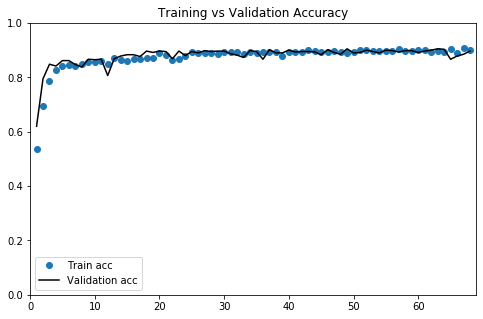

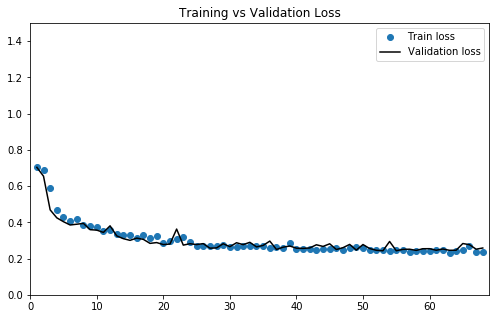

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

eps = len(acc)+1

plt.figure(figsize=(8,5))
plt.plot(epochs,acc,'o',label='Train acc')
plt.plot(epochs,val_acc,'k',label='Validation acc')
plt.axis([0,eps,0,1])
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8.23,5))
plt.plot(epochs,loss,'o',label='Train loss')
plt.plot(epochs,val_loss,'k',label='Validation loss')
plt.axis([0,eps,0,1.5])
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [41]:
# Loading various saved models
#saved_best1 = load_model('best_model.h5')
saved_best2 = load_model('best_model_2.h5')
#saved_best3 = load_model('best_model_3.h5')
#saved_best4 = load_model('best_model_4.h5')

In [163]:
test_loss, test_acc = saved_best2.evaluate(x_test2,y_test2,verbose=0)
print(test_acc)

0.918749988079071


In [164]:
ynew_best2 = saved_best2.predict_classes(x_test2)
f1_score(y_test2,ynew_best2)

0.922894424673784

In [31]:
saved_best2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 9, 9, 32)          9248      
_________________________________________________________________
dropout_9 (Dropout)          (None, 9, 9, 32)         

***

#### ProNet (best_model_2) Generalizability

In [68]:
directory = 'b_cancer_ims'
rgb_accs_ProNet = []
for i in range(30):
    gray_test_labels = [] # 0 = no IDC, 1 = IDC
    gray_test_ims = [] # populate with + images

    # Selecting random group of conseccutive patients
    start_pat1 = random.randint(1,270) # len(os.listdir(directory)) = 280
    end_pat = start_pat1 + random.randint(1,3) # Picking at most 3 patients worth of data. Want quick computations

    for folder1 in os.listdir(directory)[start_pat1:end_pat]:
        for folder2 in os.listdir(directory+'/'+folder1):
            for image in os.listdir(directory+'/'+folder1+'/'+folder2)[1:]: #first path not-included
                #print(directory+'/'+folder1+'/'+folder2+'/'+image)
                im = Image.open(directory+'/'+folder1+'/'+folder2+'/'+image) ################ RGB
                if im.size == (50,50): # Discarding non-standardized images.
                    if (image[-5]=='0'):
                        gray_test_ims.append(asarray(im)/255)
                        gray_test_labels.append(0)
                    else:
                        gray_test_ims.append(asarray(im)/255)
                        gray_test_labels.append(1)

    gray_test_ims = np.array(gray_test_ims)
    gray_test_labels = np.array(gray_test_labels)
    
    print(start_pat1)
    test_loss, test_acc = saved_best1.evaluate(gray_test_ims, gray_test_labels, verbose=0)
    rgb_accs_ProNet.append(test_acc)

7
159
90
214
235
28
177
24
48
147
123
87
65
267
37
10
22
88
30
251
36
72
149
77
98
233
87
220
49
174


In [69]:
print(np.mean(rgb_accs_ProNet))
print(np.std(rgb_accs_ProNet))

0.7573749661445618
0.09585876083503603


***

## AlexNet from Janoczyk & Madabhushi

Resizing the images to (32,32,3)

In [167]:
# Looping over full b cancer img directory
directory = 'b_cancer_ims'
labels_n = [] # 0 = no IDC, 1 = IDC
labels_p = [] 
ims2_p = [] # populate with + images
ims2_n = [] 

imsize = 32

start_pat1 = 93 # Used random.randint(1,270) to get a number, and stuck with it.
end_pat = start_pat1 + 7 # Don't want too many images

for folder1 in os.listdir(directory)[start_pat1:end_pat]:
    for folder2 in os.listdir(directory+'/'+folder1):
        for image in os.listdir(directory+'/'+folder1+'/'+folder2)[1:]: #first path not-included
            #print(directory+'/'+folder1+'/'+folder2+'/'+image)
            im = Image.open(directory+'/'+folder1+'/'+folder2+'/'+image) ############################## RGB
            im = im.resize((imsize,imsize))
            #if im.size == (50,50): # Discarding non-standardized images, first, will resize later...
            if (image[-5]=='0'):
                ims2_n.append(asarray(im)/255)
                labels_n.append(asarray(0))
            else:
                ims2_p.append(asarray(im)/255)
                labels_p.append(asarray(1))

ims2_n = np.array(ims2_n)
ims2_p = np.array(ims2_p)
labels_p = np.array(labels_p)
labels_n = np.array(labels_n)

# Equalize num of +/- cases
if len(ims2_p)>len(ims2_n):
    ims2_p = ims2_p[0:len(ims2_n)]
    labels_p = labels_p[0:len(labels_n)]
else: 
    ims2_n = ims2_n[0:len(ims2_p)]
    labels_n = labels_n[0:len(labels_p)]
    
labels = np.concatenate((labels_p,labels_n))
ims2 = np.concatenate((ims2_p,ims2_n))

unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
print('Total instances = ',2*counts[0])

{0: 1599, 1: 1599}
Total instances =  3198


In [168]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(ims2, labels, test_size=0.25)

In [150]:
alex = models.Sequential()

alex.add(layers.Conv2D(32, (5,5), input_shape=(32,32,3), strides=(1,1), padding='same', activation = "relu"))

alex.add(layers.MaxPool2D((3,3), strides=(2,2)))
alex.add(layers.Activation(activations.relu))

alex.add(layers.Conv2D(32, (5,5), strides=(1,1), padding='same',activation = "relu"))

alex.add(layers.AveragePooling2D((3,3), strides=(2,2)))

alex.add(layers.Conv2D(64, (5,5), strides=(1,1), activation = "relu"))

alex.add(layers.AveragePooling2D((3,3), strides=(2,2)))

alex.add(layers.Flatten())
#alex.add(layers.Dropout(0.5))
alex.add(layers.Dense(64, activation = "relu"))
#alex.add(layers.Dropout(0.5))
alex.add(layers.Dense(1, activation = "sigmoid")) # softmax stinks!!

opt = optimizers.Adagrad(learning_rate=5e-4) 

alex.compile(optimizer= opt,
              loss= 'binary_crossentropy',
              metrics=['acc'])

In [151]:
alex.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_123 (Conv2D)          (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
activation_42 (Activation)   (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 15, 15, 32)        25632     
_________________________________________________________________
average_pooling2d_78 (Averag (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 3, 3, 64)          51264     
_________________________________________________________________
average_pooling2d_79 (Averag (None, 1, 1, 64)        

In [152]:
ep = 40 # Num epochs

mc = ModelCheckpoint('best_model_alex.h5', monitor='val_loss', mode='min', verbose=1,save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = alex.fit(x_train2,y_train2,epochs=ep,validation_split=0.25,callbacks=[es,mc])

Train on 1798 samples, validate on 600 samples
Epoch 1/40
1798/1798 [==============================] - 3s 2ms/step - loss: 0.6562 - acc: 0.6407 - val_loss: 0.6212 - val_acc: 0.5950

Epoch 00001: val_loss improved from inf to 0.62121, saving model to best_model_alex.h5
Epoch 2/40
1798/1798 [==============================] - 2s 1ms/step - loss: 0.5423 - acc: 0.7786 - val_loss: 0.5669 - val_acc: 0.6683

Epoch 00002: val_loss improved from 0.62121 to 0.56687, saving model to best_model_alex.h5
Epoch 3/40
1798/1798 [==============================] - 2s 1ms/step - loss: 0.4751 - acc: 0.8087 - val_loss: 0.5111 - val_acc: 0.7367

Epoch 00003: val_loss improved from 0.56687 to 0.51113, saving model to best_model_alex.h5
Epoch 4/40
1798/1798 [==============================] - 2s 1ms/step - loss: 0.4433 - acc: 0.8115 - val_loss: 0.4577 - val_acc: 0.8300

Epoch 00004: val_loss improved from 0.51113 to 0.45766, saving model to best_model_alex.h5
Epoch 5/40
1798/1798 [==============================]

In [165]:
saved_alex = load_model('best_model_alex.h5')

In [169]:
ynew = saved_alex.predict_classes(x_test2)

In [170]:
f1_score(y_test2,ynew) # F1-score

0.8633754305396097

In [171]:
test_loss, test_acc = saved_alex.evaluate(x_test2,y_test2,verbose=0)
print(test_acc)

0.8512499928474426


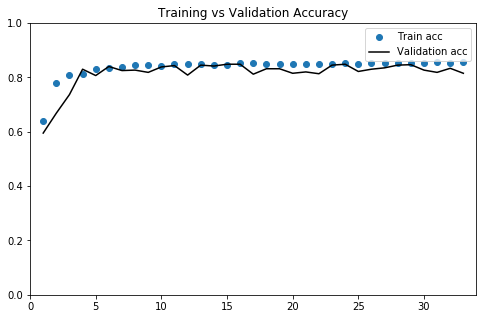

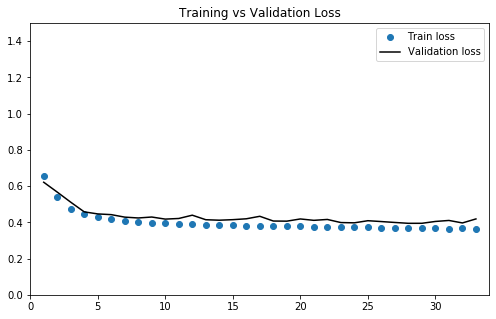

In [174]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

eps = len(acc)+1

plt.figure(figsize=(8,5))
plt.plot(epochs,acc,'o',label='Train acc')
plt.plot(epochs,val_acc,'k',label='Validation acc')
plt.axis([0,eps,0,1])
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8.23,5))
plt.plot(epochs,loss,'o',label='Train loss')
plt.plot(epochs,val_loss,'k',label='Validation loss')
plt.axis([0,eps,0,1.5])
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

***

#### AlexNet Generalizability

In [53]:
saved_best_alex = load_model('best_model_alex.h5')

In [70]:
directory = 'b_cancer_ims'
rgb_accs_Alex = []
imsize=32
for i in range(30):
    gray_test_labels = [] # 0 = no IDC, 1 = IDC
    gray_test_ims = [] # populate with + images

    # Selecting random group of conseccutive patients
    start_pat1 = random.randint(1,270) # len(os.listdir(directory)) = 280
    end_pat = start_pat1 + random.randint(1,3) # Picking at most 3 patients worth of data. Want quick computations

    for folder1 in os.listdir(directory)[start_pat1:end_pat]:
        for folder2 in os.listdir(directory+'/'+folder1):
            for image in os.listdir(directory+'/'+folder1+'/'+folder2)[1:]: #first path not-included
                #print(directory+'/'+folder1+'/'+folder2+'/'+image)
                im = Image.open(directory+'/'+folder1+'/'+folder2+'/'+image) ################ RGB
                im = im.resize((imsize,imsize))
                if (image[-5]=='0'):
                    gray_test_ims.append(asarray(im)/255)
                    gray_test_labels.append(0)
                else:
                    gray_test_ims.append(asarray(im)/255)
                    gray_test_labels.append(1)

    gray_test_ims = np.array(gray_test_ims)
    gray_test_labels = np.array(gray_test_labels)
    
    print(start_pat1)
    test_loss, test_acc = saved_best_alex.evaluate(gray_test_ims, gray_test_labels, verbose=0)
    rgb_accs_Alex.append(test_acc)

188
184
198
192
192
211
181
184
120
115
253
203
210
221
40
145
12
182
146
217
157
254
74
82
213
126
176
55
160
258


In [71]:
print(np.mean(rgb_accs_Alex))
print(np.std(rgb_accs_Alex))

0.7140772660573323
0.1278014579018601


***

Tasks: <br>
(1 - D) Code a way to easily access all files from "b_cancer_ims" dataset.
> (A) First code for one patient. <br>

(2 - D) Images are already rescaled to (50 px x 50 px), need to grayscale, first. <br>
(3 - D) Run the NN from the tutorial on one patient. <br>
(4 - D) Loop through a few patients, to make sure accessing code works. <br>
(5 - D) Repeat steps (2)-(3) until you can loop through at least 50% of all patients. <br>
(6) Read about CNN theory.
> (A - D) Review Deep Feedforward Network, architecture included (Ch. 6, Goodfellow) <br>
> (B - D) Read about CNN theory (Ch. 9, Goodfellow) <br>
>> (i) Read more on parameter sharing. <br>
>> (ii) Other examples of convolutions (https://en.wikipedia.org/wiki/Convolution#Applications) <br>

> (C - D) Study CNN architecture (Stanford CS231n) <br>
> (D - D) Read about Computer Vision (Ch. 12.2, Goodfellow) <br>
> (E) History of Machine and Deep Learning (Introduction, Goodfellow; Ch. 1, Chollet) <br>
> (F) Read at least classification portion of main paper (Janowczyk & Madabhushi)

(7 - D) Go through TensorFlow CNN Tutorial

Sub-tasks (interesting explorations): <br>
(1 - D) Simple Feed Forward (FF) NN w/ gray <br>
(2 - D) Simple FFNN w/ color <br>
(3) CNN <br>
(4 - D) Data does not seem processed in the correct shapes... <br>
(5 - D) Use SVD to compress the images? <br>
(6 - D) Find out why the tutorial NN yields basically the same test accuracies for both grayscale and color. <br>
(7) Figure out a way to introduce image rotations. <br>
(8) Zero-padding. <br>
(9 - D) Using different filters for different portions of the images ... Split the images up further. <br>
(10 - D) Why does RELU seemingly perform the best? <br>
(11 - D) Dropouts? <br>

***

A few observations
> Observation: Will probably want to explore optimizing over the number of epochs. With 7 epochs, test_acc = 0.88, with 10 epochs, test_acc = 0.86. <br>
> Observation: With just 3 epochs, we were able to increase the test accuracy by about 4%. <br>
> Observation: If I changed all the loss functions to sigmoid, I get the same result as without the CNN!!

These observations are probably the result of overfitting!! Couple things to try: <br>
> (1) Optimize over the number of epochs (Use the loss function accuracies and other metrics from the model after it's fitted.) <br>
> (2) Introduce regularization. <br>
> (3) Dropouts. <br>
> (4) k-fold validation. <br>
> (5) Note: there are more (-) cases than (+), perhaps vet your data, so that you are choosing and even number of each? However, in general there should be more (-) cases than (+) for any disease, so is this dataset representative of the population? (Look into this, if time allows...)

***

#### Making folders for data used in project. Only took patients 93 - 100 image patches. (Note: The code below does not equalize the number of +/- cases.)

In [3]:
# Creating data folders for patients 93 - 100 image patches, Note: # of +/- cases not equalized.
directory = 'b_cancer_ims'

base_dir = 'b_cancer_small'
os.mkdir(base_dir)

idc_p = os.path.join(base_dir,'IDCn') # + cases
os.mkdir(idc_p)

idc_n = os.path.join(base_dir,'IDCp') # - cases
os.mkdir(idc_n)

# destination directories
dst_dir1 = idc_n
dst_dir2 = idc_p

start_pat0 = 93 # random.randint(1,270) # len(os.listdir(directory)) = 280
end_pat0 = start_pat0 + 7 # Don't want too many images

for folder1 in os.listdir(directory)[start_pat0:end_pat0]:
    for folder2 in os.listdir(directory+'/'+folder1):
        for image in os.listdir(directory+'/'+folder1+'/'+folder2)[1:]:
            im = Image.open(directory+'/'+folder1+'/'+folder2+'/'+image)
            
            src_dir = directory+'/'+folder1+'/'+folder2+'/'+image
            if ((image.endswith(".png")) and (im.size == (50,50))):
                if (image[-5]=='0'):
                    shutil.copy(src_dir,dst_dir1)
                else:
                    shutil.copy(src_dir,dst_dir2)
                    